In [4]:
import os, sys
import glob
import kagglehub

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
import keras 

C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")


Keras version: 3.7.0
TensorFlow version: 2.19.0


In [3]:
RANDOM_STATE = 42
IMAGE_SHAPE = (48, 48)
INPUT_SHAPE = (48, 48, 1)
EPOCHS = 300
BATCH_SIZE = 32
NUM_CLASSES = 7

In [5]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

data = path

Path to dataset files: C:\Users\weare\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [7]:
os.chdir(data)
print(os.listdir())
print(os.listdir("train"))

['test', 'train']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
train_path = r'train'
test_path = r'test'

Data Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# augmenting images for training set
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 15, 
    width_shift_range = 10,
    height_shift_range = 10, 
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    validation_split = 0.2
)

# only normalizing the pixel values for the testing set
test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# read the data from directory 
train_gen = train_datagen.flow_from_directory(
    train_path, 
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE, 
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training' # train 0.8
)

val_gen = train_datagen.flow_from_directory(
    train_path, 
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE, 
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation' # val 0.2
)

test_gen = test_datagen.flow_from_directory(
    test_path, 
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE, 
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = False,
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


EDA

In [13]:
emotions = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

Class [0 1 2 3 4 5 6]
Count [3196  349 3278 5772 3972 3864 2537]



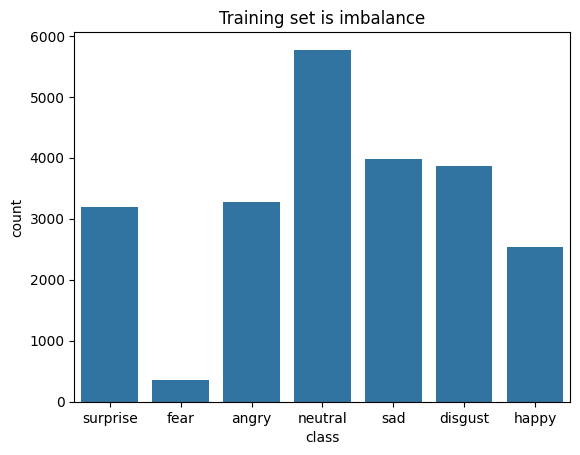

In [14]:
class_count = np.unique(train_gen.classes, return_counts = True)

print("Class", class_count[0])
print("Count", class_count[1])
print()

plt.figure()

sns.barplot(x = emotions, y = class_count[1])

plt.title("Training set is imbalance")
plt.xlabel('class')
plt.ylabel('count') 
plt.show()

In [15]:
from sklearn.utils.class_weight import compute_class_weight

In [16]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights

array([1.02664044, 9.40155546, 1.00095877, 0.56845857, 0.82606819,
       0.84915705, 1.29331607])

In [17]:
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: np.float64(1.0266404434114071),
 1: np.float64(9.401555464592715),
 2: np.float64(1.0009587727708533),
 3: np.float64(0.5684585684585685),
 4: np.float64(0.826068191627104),
 5: np.float64(0.8491570541259982),
 6: np.float64(1.2933160650937552)}

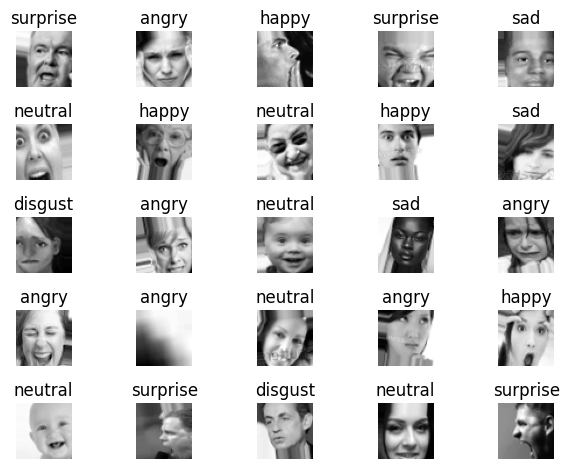

In [18]:
fig, axes = plt.subplots(ncols = 5, nrows = 5)
axes =axes.flatten()

for i in range(25):
    j = np.random.randint(train_gen.n)

    # take data 
    batch_images, batch_labels = train_gen[j // BATCH_SIZE]
    id_in_batch = j % BATCH_SIZE 
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(emotions[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Modelling

In [23]:
model = keras.models.Sequential([
    keras.Input(shape = INPUT_SHAPE),
    # 32
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 64
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 128
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 256
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 512
    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 1024
    keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    # Dense layers
    #Global Average Pooling layer is used instead of Flatten as it is more effiecient
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6), 
    metrics = ['accuracy']
)

C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 24, 24, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 24, 24, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 12, 12, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 12, 12, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 6, 6, 256)      │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,598,503 (78.58 MB)

 Trainable params: 20,588,647 (78.54 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [25]:
# define earlystopping callback
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                   min_delta = 0,
                                   patience = 3, 
                                   verbose = 1,
                                   restore_best_weights = True)

# define modelcheckpointt callback
cp = keras.callbacks.ModelCheckpoint(filepath = "ferNet.keras",
                     save_best_only = True,
                     verbose = 1,
                     mode = 'min')

CALLBACKS  = [cp, es]

In [26]:
H = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    class_weight = d_class_weights
)

Epoch 1/300


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.25036195],
         [0.2804368 ],
         [0.31102106],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04313726]],

        [[0.24908513],
         [0.279958  ],
         [0.31030285],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04313726]],

        [[0.24780828],
         [0.27947918],
         [0.30958462],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04313726]],

        ...,

        [[0.7350795 ],
         [0.7203865 ],
         [0.6992172 ],
         ...,
         [0.73333335],
         [0.73333335],
         [0.73333335]],

        [[0.72026587],
         [0.7567897 ],
         [0.7724469 ],
         ...,
         [0.7419177 ],
         [0.7421034 ],
         [0.74228907]],

        [[0.7718144 ],
         [0.7677011 ],
         [0.8015652 ],
         ...,
         [0.75538504],
         [0.7555707 ],
         [0.7557564 ]]],


       [[[0.8196079 ],
         [0.82522464],
         [0.8691994 ],
         ...,
         [0.16566765],
         [0.23074926],
         [0.2422562 ]],

        [[0.8196079 ],
         [0.82351345],
         [0.86834383],
         ...,
         [0.22685479],
         [0.2348626 ],
         [0.23963387]],

        [[0.8341596 ],
         [0.83687687],
         [0.87144226],
         ...,
         [0.25030255],
         [0.24608505],
         [0.23097335]],

        ...,

        [[0.49717307],
         [0.497975  ],
         [0.49877688],
         ...,
         [0.57103086],
         [0.58538586],
         [0.58068955]],

        [[0.55063814],
         [0.55264294],
         [0.5546476 ],
         ...,
         [0.552671  ],
         [0.5673629 ],
         [0.5686275 ]],

        [[0.6079181 ],
         [0.6097892 ],
         [0.61166024],
         ...,
         [0.55252844],
         [0.56679255],
         [0.5686275 ]]],


       [[[0.73073626],
         [0.5368304 ],
         [0.3848941 ],
         ...,
         [0.44838223],
         [0.49656978],
         [0.5480812 ]],

        [[0.74236244],
         [0.5456503 ],
         [0.39371398],
         ...,
         [0.3665776 ],
         [0.4138346 ],
         [0.4969465 ]],

        [[0.7539887 ],
         [0.5544702 ],
         [0.40253386],
         ...,
         [0.37363163],
         [0.3971812 ],
         [0.39750108]],

        ...,

        [[0.9993616 ],
         [0.9922601 ],
         [0.99543864],
         ...,
         [0.8148026 ],
         [0.9729932 ],
         [0.9936649 ]],

        [[0.9991301 ],
         [0.99735403],
         [0.9978013 ],
         ...,
         [0.93005973],
         [0.99340963],
         [0.9943489 ]],

        [[0.99608   ],
         [0.9988772 ],
         [0.99557173],
         ...,
         [0.98625785],
         [0.98489255],
         [0.9944734 ]]],


       ...,


       [[[0.50980395],
         [0.50980395],
         [0.5102523 ],
         ...,
         [0.32818428],
         [0.27995247],
         [0.25357053]],

        [[0.50980395],
         [0.50980395],
         [0.50980395],
         ...,
         [0.3338037 ],
         [0.28266066],
         [0.2589416 ]],

        [[0.50980395],
         [0.50980395],
         [0.50980395],
         ...,
         [0.34100744],
         [0.2881694 ],
         [0.2614841 ]],

        ...,

        [[0.307758  ],
         [0.31018904],
         [0.31262007],
         ...,
         [0.2684978 ],
         [0.22285034],
         [0.17558415]],

        [[0.3507452 ],
         [0.35601243],
         [0.36127967],
         ...,
         [0.20527193],
         [0.1630259 ],
         [0.15479207]],

        [[0.39963236],
         [0.40408927],
         [0.40854618],
         ...,
         [0.16377194],
         [0.1603414 ],
         [0.16112201]]],


       [[[0.7885344 ],
         [0.79068756],
         [0.83588755],
         ...,
         [0.6310091 ],
         [0.6284205 ],
         [0.650441  ]],

        [[0.77023983],
         [0.7734696 ],
         [0.81482625],
         ...,
         [0.62336445],
         [0.6271723 ],
         [0.6296376 ]],

        [[0.7377143 ],
         [0.7447121 ],
         [0.81363374],
         ...,
         [0.6563908 ],
         [0.65348977],
         [0.6433202 ]],

        ...,

        [[0.77673376],
         [0.74345493],
         [0.7186162 ],
         ...,
         [0.6901961 ],
         [0.6901961 ],
         [0.6901961 ]],

        [[0.7745433 ],
         [0.7379787 ],
         [0.71587807],
         ...,
         [0.6901961 ],
         [0.6901961 ],
         [0.6901961 ]],

        [[0.77205837],
         [0.7329179 ],
         [0.71243733],
         ...,
         [0.6901961 ],
         [0.6901961 ],
         [0.6901961 ]]],


       [[[0.75242615],
         [0.6137023 ],
         [0.66531897],
         ...,
         [0.509176  ],
         [0.52156866],
         [0.52156866]],

        [[0.7368395 ],
         [0.6119705 ],
         [0.6718134 ],
         ...,
         [0.51004195],
         [0.52156866],
         [0.52156866]],

        [[0.72125286],
         [0.6102386 ],
         [0.67830783],
         ...,
         [0.5109078 ],
         [0.52156866],
         [0.52156866]],

        ...,

        [[0.48490646],
         [0.4769243 ],
         [0.44250363],
         ...,
         [0.28103665],
         [0.28001088],
         [0.27898514]],

        [[0.4941814 ],
         [0.49902222],
         [0.4711109 ],
         ...,
         [0.30119833],
         [0.30017257],
         [0.2991468 ]],

        [[0.5017496 ],
         [0.507585  ],
         [0.4850925 ],
         ...,
         [0.3121986 ],
         [0.31240377],
         [0.31260893]]]], dtype=float32), array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)).
Traceback (most recent call last):

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\util\nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1427, in _tf_data_assert_shallow_structure
    raise ValueError(

ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.25036195],
         [0.2804368 ],
         [0.31102106],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04313726]],

        [[0.24908513],
         [0.279958  ],
         [0.31030285],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04313726]],

        [[0.24780828],
         [0.27947918],
         [0.30958462],
         ...,
         [0.04313726],
         [0.04313726],
         [0.04313726]],

        ...,

        [[0.7350795 ],
         [0.7203865 ],
         [0.6992172 ],
         ...,
         [0.73333335],
         [0.73333335],
         [0.73333335]],

        [[0.72026587],
         [0.7567897 ],
         [0.7724469 ],
         ...,
         [0.7419177 ],
         [0.7421034 ],
         [0.74228907]],

        [[0.7718144 ],
         [0.7677011 ],
         [0.8015652 ],
         ...,
         [0.75538504],
         [0.7555707 ],
         [0.7557564 ]]],


       [[[0.8196079 ],
         [0.82522464],
         [0.8691994 ],
         ...,
         [0.16566765],
         [0.23074926],
         [0.2422562 ]],

        [[0.8196079 ],
         [0.82351345],
         [0.86834383],
         ...,
         [0.22685479],
         [0.2348626 ],
         [0.23963387]],

        [[0.8341596 ],
         [0.83687687],
         [0.87144226],
         ...,
         [0.25030255],
         [0.24608505],
         [0.23097335]],

        ...,

        [[0.49717307],
         [0.497975  ],
         [0.49877688],
         ...,
         [0.57103086],
         [0.58538586],
         [0.58068955]],

        [[0.55063814],
         [0.55264294],
         [0.5546476 ],
         ...,
         [0.552671  ],
         [0.5673629 ],
         [0.5686275 ]],

        [[0.6079181 ],
         [0.6097892 ],
         [0.61166024],
         ...,
         [0.55252844],
         [0.56679255],
         [0.5686275 ]]],


       [[[0.73073626],
         [0.5368304 ],
         [0.3848941 ],
         ...,
         [0.44838223],
         [0.49656978],
         [0.5480812 ]],

        [[0.74236244],
         [0.5456503 ],
         [0.39371398],
         ...,
         [0.3665776 ],
         [0.4138346 ],
         [0.4969465 ]],

        [[0.7539887 ],
         [0.5544702 ],
         [0.40253386],
         ...,
         [0.37363163],
         [0.3971812 ],
         [0.39750108]],

        ...,

        [[0.9993616 ],
         [0.9922601 ],
         [0.99543864],
         ...,
         [0.8148026 ],
         [0.9729932 ],
         [0.9936649 ]],

        [[0.9991301 ],
         [0.99735403],
         [0.9978013 ],
         ...,
         [0.93005973],
         [0.99340963],
         [0.9943489 ]],

        [[0.99608   ],
         [0.9988772 ],
         [0.99557173],
         ...,
         [0.98625785],
         [0.98489255],
         [0.9944734 ]]],


       ...,


       [[[0.50980395],
         [0.50980395],
         [0.5102523 ],
         ...,
         [0.32818428],
         [0.27995247],
         [0.25357053]],

        [[0.50980395],
         [0.50980395],
         [0.50980395],
         ...,
         [0.3338037 ],
         [0.28266066],
         [0.2589416 ]],

        [[0.50980395],
         [0.50980395],
         [0.50980395],
         ...,
         [0.34100744],
         [0.2881694 ],
         [0.2614841 ]],

        ...,

        [[0.307758  ],
         [0.31018904],
         [0.31262007],
         ...,
         [0.2684978 ],
         [0.22285034],
         [0.17558415]],

        [[0.3507452 ],
         [0.35601243],
         [0.36127967],
         ...,
         [0.20527193],
         [0.1630259 ],
         [0.15479207]],

        [[0.39963236],
         [0.40408927],
         [0.40854618],
         ...,
         [0.16377194],
         [0.1603414 ],
         [0.16112201]]],


       [[[0.7885344 ],
         [0.79068756],
         [0.83588755],
         ...,
         [0.6310091 ],
         [0.6284205 ],
         [0.650441  ]],

        [[0.77023983],
         [0.7734696 ],
         [0.81482625],
         ...,
         [0.62336445],
         [0.6271723 ],
         [0.6296376 ]],

        [[0.7377143 ],
         [0.7447121 ],
         [0.81363374],
         ...,
         [0.6563908 ],
         [0.65348977],
         [0.6433202 ]],

        ...,

        [[0.77673376],
         [0.74345493],
         [0.7186162 ],
         ...,
         [0.6901961 ],
         [0.6901961 ],
         [0.6901961 ]],

        [[0.7745433 ],
         [0.7379787 ],
         [0.71587807],
         ...,
         [0.6901961 ],
         [0.6901961 ],
         [0.6901961 ]],

        [[0.77205837],
         [0.7329179 ],
         [0.71243733],
         ...,
         [0.6901961 ],
         [0.6901961 ],
         [0.6901961 ]]],


       [[[0.75242615],
         [0.6137023 ],
         [0.66531897],
         ...,
         [0.509176  ],
         [0.52156866],
         [0.52156866]],

        [[0.7368395 ],
         [0.6119705 ],
         [0.6718134 ],
         ...,
         [0.51004195],
         [0.52156866],
         [0.52156866]],

        [[0.72125286],
         [0.6102386 ],
         [0.67830783],
         ...,
         [0.5109078 ],
         [0.52156866],
         [0.52156866]],

        ...,

        [[0.48490646],
         [0.4769243 ],
         [0.44250363],
         ...,
         [0.28103665],
         [0.28001088],
         [0.27898514]],

        [[0.4941814 ],
         [0.49902222],
         [0.4711109 ],
         ...,
         [0.30119833],
         [0.30017257],
         [0.2991468 ]],

        [[0.5017496 ],
         [0.507585  ],
         [0.4850925 ],
         ...,
         [0.3121986 ],
         [0.31240377],
         [0.31260893]]]], dtype=float32), array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_27454]